In [1]:
from collections import defaultdict
import itertools
import json
import sys
import os
from datasets import load_dataset

from matplotlib import pyplot as plt

_PATH = '/home/sireesh/current_semester/11-797_QA/11-797-multidoc2dial/multidoc2dial/'
sys.path.append(os.path.join(_PATH))  # noqa: E402 # isort:skip

In [2]:
val_data = json.load(open(_PATH + 'data/multidoc2dial/multidoc2dial_dial_validation.json','r'))
docs = json.load(open(_PATH + 'data/multidoc2dial/multidoc2dial_doc.json','r'))

# dialogue act type. Are these all `query_condition?`
DAs      = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('da'), "r").readlines()]
# domain - dmv, ssa, studentaid, va
domains  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('domain'), "r").readlines()]
# gold passage ID to answer this question
pids     = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('pids'), "r").readlines()]
# query IDs, in the format {ID}_{turn}
qids     = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('qids'), "r").readlines()]
# the actual text of the query
sources  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('source'), "r").readlines()]
# Gold responses
targets  = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('target'), "r").readlines()]
# Gold article titles
titles   = [line.strip() for line in open(_PATH + 'data/mdd_all/dd-generation-structure/val.{}'.format('titles'), "r").readlines()]

In [3]:
# making sure we have the same number of document turns here.
len(DAs), len(domains), len(pids), len(qids), len(sources), len(targets), len(titles)

(4201, 4201, 4201, 4201, 4201, 4201, 4201)

In [4]:
retr_results = [line.replace('####', '\t').replace('\n', '').split('\t') for line in open('Results_retrieval.txt', "r").readlines()]
grounding_pids = []
grounding_titles = []
for x in retr_results:
    len_ = len(x)
    grounding_titles.append(x[:len_//2])
    grounding_pids.append(x[len_//2:])


hypos = [line.strip() for line in open('Results_generation.txt', "r").readlines()]
assert len(DAs) == len(domains) == len(pids) == len(qids) == len(sources) == len(targets) == len(titles) == len(retr_results) == len(hypos)

In [5]:
misses = defaultdict(lambda:0)
turn_to_rank_map = defaultdict(lambda: [])
turns = defaultdict(lambda: 0)

for correct_pid, retrieved_pids, query_id in zip(pids, grounding_pids, qids):
    query_group, turn_id = query_id.split("_")
    turns[int(turn_id)] += 1
    if correct_pid not in retrieved_pids:
        misses[int(turn_id)] += 1
    else:
        turn_to_rank_map[int(turn_id)].append(retrieved_pids.index(correct_pid) + 1)

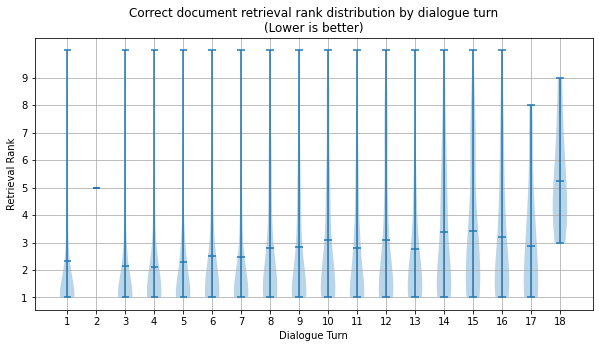

In [6]:
fig, axes = plt.subplots(figsize=(10,5))
axes.set_title("Correct document retrieval rank distribution by dialogue turn\n(Lower is better)")
axes.grid()
axes.set_xticks(list(range(1,19)))
axes.set_yticks(list(range(10)))
axes.set_xlabel("Dialogue Turn")
axes.set_ylabel("Retrieval Rank")
plt.violinplot([turn_to_rank_map[i] for i in range(1,19)], showmeans=True);

<BarContainer object of 18 artists>

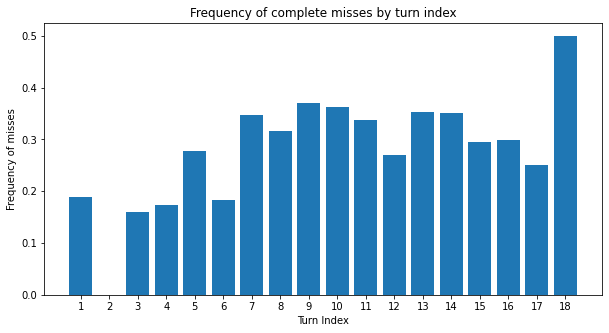

In [7]:
fig, axes = plt.subplots(figsize=(10,5))
axes.set_title("Frequency of complete misses by turn index")
axes.set_xlabel("Turn Index")
axes.set_xticks(list(range(1,19)))
axes.set_ylabel("Frequency of misses")

miss_freq = {i: misses[i] / turns[i] for i in range(1,19)}
pos, height = zip(*[(i, miss_freq[i]) for i in range(1,19)])
axes.bar(pos, height)

In [8]:
'''
import string
import re
from collections import Counter


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)

from sacrebleu import corpus_bleu
def calculate_bleu(output_lns, refs_lns) -> dict:
    """Uses sacrebleu's corpus_bleu implementation."""
    return round(corpus_bleu(output_lns, [refs_lns]).score, 4)
'''

from scripts.rag.utils_rag import exact_match_score, f1_score

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    return max(metric_fn(prediction, gt) for gt in ground_truths)

from datasets import load_metric
metric = load_metric("sacrebleu")

generation_metrics = []
metrics_by_query = defaultdict(lambda: [])
metrics_by_turn_no = defaultdict(lambda: [])

for qid, prediction, ground_truths in zip(qids, hypos, targets):
    query_group, turn_id = qid.split("_")
    em_i = metric_max_over_ground_truths(exact_match_score, prediction, [ground_truths]) 
    f1_i = metric_max_over_ground_truths(f1_score, prediction, [ground_truths])
    metric.add_batch(predictions=[prediction], references=[[ground_truths]])
    sbleu_i = metric.compute()["score"]
    metrics_dict = {'EM' : em_i, 'F1' : f1_i, 'sacrebleu' : sbleu_i}
    generation_metrics.append(metrics_dict)
    metrics_by_query[query_group].append(metrics_dict)
    metrics_by_turn_no[turn_id].append(metrics_dict)

'''
tt = 0
refs = [ [target]  for target in targets]
for u in range(len(hypos)):
    metric.add_batch(predictions=hypos[u:u+1], references=refs[u:u+1])
    sbleu_i = metric.compute()["score"]
    tt = tt + sbleu_i
print (tt/len(hypos))
''';   


In [9]:
turns, f1s = list(zip(*list(itertools.chain(*[[(int(turn), metrics_dict["F1"]) for metrics_dict in metrics] for turn, metrics in metrics_by_turn_no.items()]))))

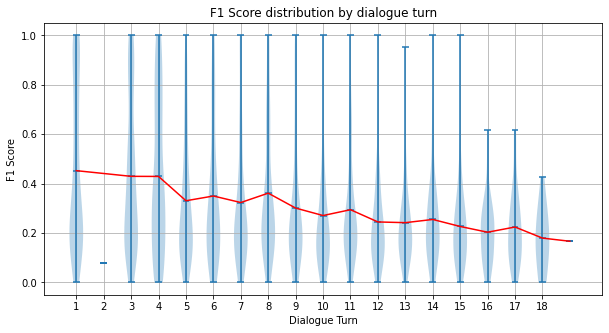

In [26]:
dataset_for_violin = {int(turn): [d["F1"] for d in metrics] for turn, metrics in metrics_by_turn_no.items()}
means = [(turn, sum(metric)/ len(metric)) for turn, metric in dataset_for_violin.items()]
means = sorted(means, key=lambda x: x[0])
del means[1]

fig, axes = plt.subplots(figsize=(10,5))
axes.set_title("F1 Score distribution by dialogue turn")
axes.set_xticks(list(range(1,19)))
axes.set_xlabel("Dialogue Turn")
axes.set_ylabel("F1 Score")
axes.grid()
plt.violinplot([dataset_for_violin[i] for i in range(1,20)], showmeans=True);
axes.plot(*zip(*means), color='red')

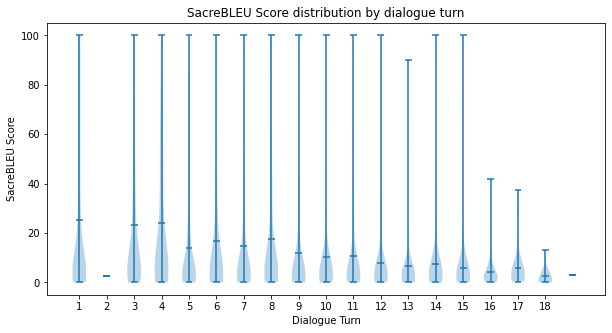

In [11]:
dataset_for_violin = {int(turn): [d["sacrebleu"] for d in metrics] for turn, metrics in metrics_by_turn_no.items()}
fig, axes = plt.subplots(figsize=(10,5))
axes.set_title("SacreBLEU Score distribution by dialogue turn")
axes.set_xticks(list(range(1,19)))
axes.set_xlabel("Dialogue Turn")
axes.set_ylabel("SacreBLEU Score")
plt.violinplot([dataset_for_violin[i] for i in range(1,20)], showmeans=True);

In [12]:
len(generation_metrics)

4201

In [13]:
def text2line(text):
    return text.replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

def split_text_section(spans, title):
    def get_text(buff, title, span):
        text = " ".join(buff).replace("\n", " ")
        parent_titles = [title.replace("/", "-").rsplit("#")[0]]
        if len(span["parent_titles"]) > 1:
            parent_titles = [ele['text'].replace("/", "-").rsplit("#")[0] for ele in span["parent_titles"]]
        text = " / ".join(parent_titles) + " // " + text
        return text2line(text)

    buff = []
    pre_sec, pre_title, pre_span = None, None, None
    passages = []
    subtitles = []
        
    for span_id in spans:
        span = spans[span_id]
        parent_titles = title
        if len(span["parent_titles"]) > 1:                        
            parent_titles = [ele['text'].replace("/", "-").rsplit("#")[0] for ele in span["parent_titles"]]
            parent_titles = " / ".join(parent_titles)
        if pre_sec == span["id_sec"] or pre_title == span["title"].strip():
            buff.append(span["text_sp"])
        elif buff:
            text = get_text(buff, title, pre_span)
            passages.append(text)
            subtitles.append(parent_titles)
            buff = [span["text_sp"]]
        else:
            buff.append(span["text_sp"])
        pre_sec = span["id_sec"]
        pre_span = span
        pre_title = span["title"].strip()
    if buff:
        text = get_text(buff, title, span)
        passages.append(text)
        subtitles.append(parent_titles)
    return passages, subtitles        

In [14]:
doc_passages = {}
all_passages = []
start_idx = 0
for domain in docs['doc_data']:
    for doc_id in docs['doc_data'][domain].keys():
        ex = docs['doc_data'][domain][doc_id]
        #passages = split_text(ex["doc_text"]) # Token-based segmentation
        passages, subtitles = split_text_section(ex["spans"], ex["title"])
        all_passages.extend(passages)
        doc_passages[ex["doc_id"]] = (start_idx, len(passages))
        start_idx += len(passages)
        
passage_map = {}
for title in doc_passages:
    psg_start_ix = doc_passages[title][0]
    n_psgs = doc_passages[title][1]
    for i in range(n_psgs):
        passage_map[psg_start_ix + i] = {"text": all_passages[psg_start_ix + i], "title": title}

In [15]:
passage_map[1806]

{'text': 'Top 5 DMV Mistakes and How to Avoid Them //   3. Letting Insurance Lapse   Because we all pay indirectly for crashes involving uninsured motorists ,  New York State requires every motorist to maintain auto insurance every single day a vehicle is registered.  DMV works with insurance companies to electronically monitor your insurance coverage ,  and we know when coverage is dropped for any reason.  When that happens ,  we mail you an insurance inquiry letter to allow you to clear up the problem.  We send 500,000 inquiry letters a year.  If the inquiry letter does not resolve the problem ,  we must suspend the vehicle registration and ,  if it persists, your driver license!We suspend 300,000 registrations a year for failure to maintain insurance.  If you fail to maintain an updated address with us ,  you won t learn that you have an insurance problem ,  and we will suspend your registration and license.  Make sure you turn in your vehicle s license plates at DMV before you canc

In [19]:
overall_perf = {'EM' : 0.0, 'F1' : 0.0, 'sacrebleu' : 0.0}
total = 0


#do_print = False
#for k in range(len(qids)):
do_print = True
for k in range(60):

    if True :  # Filtering Condition  
        overall_perf['EM'] += int(generation_metrics[k]['EM'])
        overall_perf['F1'] += generation_metrics[k]['F1']
        overall_perf['sacrebleu'] += generation_metrics[k]['sacrebleu']
        total += 1
        
        if do_print :         
            print ('Query ID       : ', qids[k])
            print ('Domain         : ', domains[k])
            print ('Query          : ', sources[k])
            print ('Dialogue Act   : ', DAs[k])
            print ('Passage (Gold) : ', pids[k])
            print ('Title   (Gold) : ', titles[k])
            print ('Response(Gold) : ', targets[k])
            print ('PID    (Retr)  : ', grounding_pids[k])
            print ('Titles (Retr)  : ', grounding_titles[k])
            print ('Pred Response  : ', hypos[k])
            print ('Perf (gen)     : ', generation_metrics[k])
            print ()
    
em = 100.0 * overall_perf['EM'] / total
f1 = 100.0 * overall_perf['F1'] / total
sb = overall_perf['sacrebleu'] / total

print(f"F1: {f1: .2f}")
print(f"EM: {em: .2f}")
print(f"sacrebleu: {sb: .2f}")
print(f"all: {f1: .2f} & {em: .2f} & {sb: .2f} ")    

Query ID       :  1409501a35697e0ce68561e29577b90a_1
Domain         :  dmv
Query          :  My insurance ended so what should i do[SEP]
Dialogue Act   :  query_condition
Passage (Gold) :  1806
Title   (Gold) :  Top 5 DMV Mistakes and How to Avoid Them#3_0
Response(Gold) :  You will need to get insurance or we will suspend your registration and license
PID    (Retr)  :  ['1806', '2829', '2825', '2441', '2340', '2456', '1421', '2346', '2004', '2455']
Titles (Retr)  :  ['Top 5 DMV Mistakes and How to Avoid Them#3_0', 'Pay insurance lapse civil penalty#1_0', 'Pay insurance lapse civil penalty#1_0', 'Provide proof of insurance#1_0', 'Insurance lapses#3_0', 'Respond to DMV insurance letters and orders#3_0', 'Access Your VA Life Insurance Policy Online | Veterans Affairs#1_0', 'Insurance lapses#3_0', 'How insurance premium reduction works#3_0', 'Respond to DMV insurance letters and orders#3_0']
Pred Response  :  you want to know what to do if your insurance lapsed?
Perf (gen)     :  {'EM': F

In [17]:
for domain in val_data['dial_data']:
    for flow in val_data['dial_data'][domain]:
        print (flow['dial_id'])
        print ("---------------------")
        for turn in flow['turns']:
            print ("turn_id      : ", turn['turn_id'])
            print ("role         : ", turn['role'])
            print ("Dialogue Act : ", turn['da'])
            print ("Utterance    : ", turn['utterance'])
            print ("Reference    : ", turn['references'])                        
            print()
        break
    break

1409501a35697e0ce68561e29577b90a
---------------------
turn_id      :  1
role         :  user
Dialogue Act :  query_condition
Utterance    :  My insurance ended so what should i do
Reference    :  [{'label': 'precondition', 'id_sp': '23', 'doc_id': 'Top 5 DMV Mistakes and How to Avoid Them#3_0'}]

turn_id      :  2
role         :  agent
Dialogue Act :  respond_solution
Utterance    :  You will need to get insurance or we will suspend your registration and license
Reference    :  [{'label': 'solution', 'id_sp': '24', 'doc_id': 'Top 5 DMV Mistakes and How to Avoid Them#3_0'}, {'label': 'solution', 'id_sp': '25', 'doc_id': 'Top 5 DMV Mistakes and How to Avoid Them#3_0'}, {'label': 'solution', 'id_sp': '26', 'doc_id': 'Top 5 DMV Mistakes and How to Avoid Them#3_0'}]

turn_id      :  3
role         :  user
Dialogue Act :  query_condition
Utterance    :  Don't do that I'll get insurance
Reference    :  [{'label': 'precondition', 'id_sp': '28', 'doc_id': 'Top 5 DMV Mistakes and How to Avoid T